<a href="https://colab.research.google.com/github/andrei-micuda/ML-Labs-2021/blob/master/CT-Scan/CT_Scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
from google.colab import drive

drive.mount('/content/drive')
file_name = "/content/drive/MyDrive/ct-scan.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall("ct-scan")
  print('Done')

Mounted at /content/drive
Done


In [10]:
import numpy as np
import os
import glob
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow.keras import layers, models, preprocessing, callbacks, regularizers, constraints
import matplotlib.pyplot as plt

img_height, img_width, img_channels = 50, 50, 1


def process_csv_entry(entry):
    img_path, label = entry.strip().split(",")
    return img_path, int(label)

def decode_img(img):
  img = PIL.Image.open(img)
  return np.asarray(img)

def load_data(dir_name, csv_file, has_labels=True):
  features = []
  if has_labels:
    labels = []
  with open(csv_file, "r") as fin:
    for entry in fin:
      img_path = entry.strip()
      if has_labels:
        img_path, label = process_csv_entry(entry)
      
      img = decode_img(dir_name + "/" + img_path)
      features.append(img)
      if has_labels:
        labels.append(label)
  if has_labels:
    return np.stack(features), np.stack(labels)
  return np.stack(features)

def preprocess_images(imgs):
  processed_images = np.copy(imgs)
  processed_images = processed_images / 255.0
  # processed_images = 255 - processed_images
  # mean = np.mean(processed_images, axis=(1, 2), keepdims=True)
  # std = np.std(processed_images, axis=(1, 2), keepdims=True)
  # processed_images = (processed_images - mean) / std
  return processed_images
  # ones = np.ones(2500).reshape((50, 50))
  # return np.subtract(ones, processed_images)


def show_data_sample(imgs, labels):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # ones = np.ones(2500).reshape((50, 50))
    plt.imshow(imgs[i])
    # plt.imshow(np.subtract(ones, imgs[i]))
    # plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

In [11]:
class_names = ["native", "arterial", "venous"]

train_ds, train_labels = load_data(r"/content/ct-scan/train", r"/content/ct-scan/train.txt")
train_labels = tf.keras.utils.to_categorical(train_labels)
# show_data_sample(train_ds, train_labels)

validation_ds, validation_labels = load_data(r"/content/ct-scan/validation", r"/content/ct-scan/validation.txt")
validation_labels = tf.keras.utils.to_categorical(validation_labels)

test_ds = load_data(r"/content/ct-scan/test", r"/content/ct-scan/test.txt", has_labels=False)

train_images = tf.expand_dims(preprocess_images(train_ds), axis=-1)
validation_images = tf.expand_dims(preprocess_images(validation_ds), axis=-1)
test_images = tf.expand_dims(preprocess_images(test_ds), axis=-1)

We are going to make 2 utility functions for quick and dirty model testing:

In [12]:
def add_layer(model, layer, is_input_layer=False, is_output_layer=False):
  weight_decay = 1e-4
  parts = [part.strip() for part in layer.split("~")]
  for part in parts:
    if part.startswith("CL"):
      part = part[2:]
      filters, kernel_size_and_padding = part.split("C")
      filters = int(filters)
      kernel_size, padd = int(kernel_size_and_padding[:-1]), kernel_size_and_padding[-1]
      if is_input_layer:
        model.add(
          layers.Conv2D(
            filters,
            (kernel_size, kernel_size),
            activation="relu",
            input_shape=(img_height, img_width, img_channels),
            padding="same" if padd == "S" else "valid"
            # kernel_regularizer=regularizers.l2(),
          )
          )
      else:
        model.add(
          layers.Conv2D(
            filters,
            (kernel_size, kernel_size),
            activation="relu",
            padding="same" if padd == "S" else "valid"
            # kernel_regularizer=regularizers.l2(weight_decay),
            )
        )
    elif part.startswith("P"):
      pool_size = int(part[1:])
      # model.add(layers.AvgPool2D(pool_size=(pool_size, pool_size)))
      model.add(layers.MaxPool2D(pool_size=(pool_size, pool_size)))
    elif part.startswith("BN"):
      if is_input_layer:
        model.add(layers.BatchNormalization(input_shape=(img_height, img_width, img_channels)))
      else:
        model.add(layers.BatchNormalization())
    elif part.startswith("DO"):
      rate = float(part[2:]) / 100.0
      if is_input_layer:
        model.add(layers.Dropout(rate, input_shape=(img_height, img_width, img_channels)))
      else:
        model.add(layers.Dropout(rate))
    elif part.startswith("F"):
      model.add(layers.Flatten())
    elif part.startswith("D"):
      units = int(part[1:])
      model.add(
          layers.Dense(
              units,
              activation="softmax" if is_output_layer else "relu",
              kernel_constraint=constraints.MaxNorm(3),
          )
      )


def create_model(pattern):
  model = models.Sequential()
  layers = [layer.strip() for layer in pattern.split("->")]
  num_layers = len(layers)
  # model.add(
  #   tf.keras.layers.experimental.preprocessing.Normalization(
  #       input_shape=(50, 50, 1)
  #   )
  # )
  # model.add(tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1))
  for i, layer in enumerate(layers):
    add_layer(model, layer, is_input_layer=(i == 0), is_output_layer=(i == num_layers - 1))
  # model.compile(
  #   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  #   loss=tf.keras.losses.CategoricalCrossentropy(),
  #   metrics=["accuracy"])
  return model

In [69]:
callbacks = [           
    tf.keras.callbacks.ModelCheckpoint('/content/ct-scan/best-weights.h5',
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True),
    # tf.keras.callbacks.EarlyStopping(
    #                     monitor='val_accuracy',
    #                     mode="max",
    #                     patience=10,
    #                     restore_best_weights=True
    #                 )
]

def model_testing(model_pattern, epochs, show_graphs=True):
  # model_patterns = ["CL48C5~P2~BN~DO1 -> CL64C5~P2~BN~DO1 -> CL128C5~BN~DO1 -> F -> D512 -> D512 -> D3"]
  model = create_model(model_pattern)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0017, epsilon=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"])

  # model.summary()

  datagen = preprocessing.image.ImageDataGenerator(
    # height_shift_range=[-5, 5],
    horizontal_flip=True,
    rotation_range=15,
    # featurewise_center=True,
    # featurewise_std_normalization=True
    # zca_whitening=True
    # zoom_range=[0.7, 1.0]
  )
  datagen.fit(train_images)
  train_images_it = datagen.flow(train_images, train_labels)
  validation_images_it = datagen.flow(validation_images, validation_labels)


  history = model.fit(
    train_images_it,
    epochs=epochs,
    validation_data=validation_images_it,
    callbacks=callbacks,
    # steps_per_epoch=468,
    shuffle=True,
  )

  if show_graphs:
    # PLOT ACCURACIES
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 12))
    fig.suptitle(model_pattern)
    ax1.plot(history.history["val_accuracy"], linestyle="solid", color="orange")
    ax1.plot(history.history["accuracy"], linestyle="solid", color="blue")
    ax1.set_xticks(range((epochs)))
    ax1.set_title("Accuracies")
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("epoch")
    ax1.legend(["val_accuracy", "accuracy"], loc="upper left")

    ax2.plot(history.history["val_loss"], linestyle="solid", color="orange")
    ax2.plot(history.history["loss"], linestyle="solid", color="blue")
    ax2.set_xticks(range((epochs)))
    ax2.set_title("Loss")
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    ax2.legend(["val_loss", "loss"], loc="upper left")
    # axes = plt.gca()
    # axes.set_ylim([0.98, 1])
    plt.show()
  
  return model

In [ ]:
# model_testing("CL12C7~CL12C7~BN~P2~DO50 -> CL24C5~CL24C5~BN~P2~DO50 -> F -> D120~DO50 -> D64~DO50 -> D3", 50)
# model = model_testing("CL32C7V~DO25~CL132C7V~DO25~BN~P2 -> CL64C5V~DO25~CL64C5V~DO25~BN~P2 -> F -> D128~DO50 -> D128~DO50 -> D3", 50)
#  model = model_testing("CL32C7V~CL32C7V~BN~P2~DO36.1 -> CL64C5V~CL64C5V~BN~P2~DO36.4 -> F -> D128~DO22.7 -> D128~DO27.4 -> D3", 100, show_graphs=True)
# model = model_testing("CL32C7V~CL32C7V~BN~P2~DO18 -> CL64C5V~CL64C5V~BN~P2~DO82 -> F -> D128~DO26 -> D128~DO62 -> D3", 100, show_graphs=True)
model = model_testing("BN -> CL32C7V~CL32C7V~BN~P2~DO18 -> CL64C5V~CL64C5V~BN~P2~DO82 -> F -> D512~DO26 -> D256~DO62 -> D3", 20, show_graphs=True)

# {'Dropout': 0.1878338127435366, 'Dropout_1': 0.8293042185943654, 'Dropout_2': 0.2698783541301023, 'Dropout_3': 0.6213265636979889}

Epoch 1/100
469/469 [==============================] - 9s 17ms/step - loss: 1.7658 - accuracy: 0.3558 - val_loss: 1.0190 - val_accuracy: 0.4853
Epoch 2/100
469/469 [==============================] - 8s 17ms/step - loss: 1.0767 - accuracy: 0.4048 - val_loss: 0.9543 - val_accuracy: 0.5138
Epoch 3/100
469/469 [==============================] - 8s 17ms/step - loss: 1.0478 - accuracy: 0.4294 - val_loss: 1.1971 - val_accuracy: 0.4887
Epoch 4/100
469/469 [==============================] - 8s 17ms/step - loss: 1.0250 - accuracy: 0.4504 - val_loss: 0.9022 - val_accuracy: 0.5020
Epoch 5/100
469/469 [==============================] - 8s 17ms/step - loss: 0.9749 - accuracy: 0.5027 - val_loss: 0.9346 - val_accuracy: 0.5424
Epoch 6/100
469/469 [==============================] - 8s 17ms/step - loss: 0.9412 - accuracy: 0.5222 - val_loss: 0.7975 - val_accuracy: 0.6196
Epoch 7/100
469/469 [==============================] - 8s 17ms/step - loss: 0.9167 - accuracy: 0.5437 - val_loss: 0.7847 - val_accuracy:

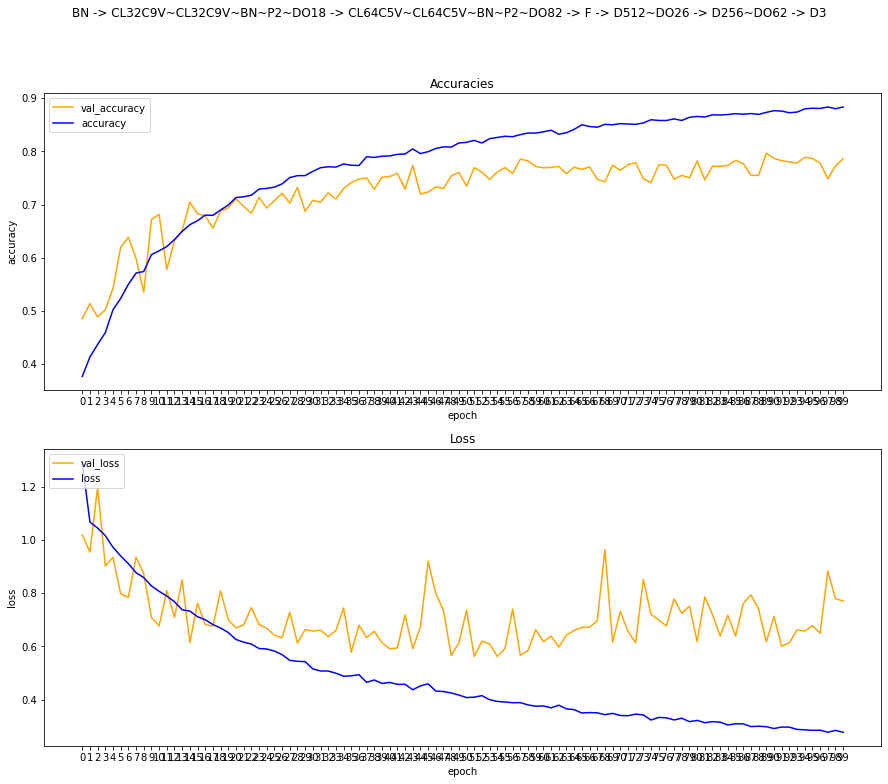

In [70]:
# model = model_testing("BN -> CL32C7V~CL32C7V~BN~P2~DO18 -> CL64C5V~CL64C5V~BN~P2~DO82 -> F -> D512~DO26 -> D256~DO62 -> D3", 50, show_graphs=True)
# model = model_testing("BN -> CL32C7V~CL32C7V~BN~P2 -> CL64C5V~CL64C5V~BN~P2 -> F -> D512 -> D256-> D3", 20, show_graphs=True)
model = model_testing("BN -> CL32C9V~CL32C9V~BN~P2~DO18 -> CL64C5V~CL64C5V~BN~P2~DO82 -> F -> D512~DO26 -> D256~DO62 -> D3", 100, show_graphs=True)

# show_data_sample(test_ds, train_labels)
model.load_weights("/content/ct-scan/best-weights.h5")
predictions = np.argmax(model.predict(test_images), axis=1)
with open("/content/ct-scan/test.txt") as fin:
  test_image_names = [line.strip() for line in fin.readlines()]
with open("/content/ct-scan/submission.txt", 'w') as fout:
  fout.write("id,label\n")
  for i, img in enumerate(test_image_names):
    fout.write(f"{img},{predictions[i]}\n")

In [59]:
import pickle

callbackLst = [             
    tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        mode="max",
                        patience=10,
                        restore_best_weights=True
                    )
]

def model_comparison(model_patterns, epochs):
    # history = [0] * len(model_patterns)
    model_patterns_valid = []
    for i, model_pattern in enumerate(model_patterns):
        try:
          model = create_model(model_pattern)
        except:
          continue
        model.compile(
          optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.CategoricalCrossentropy(),
          metrics=["accuracy"])

        # model.summary()

        datagen = preprocessing.image.ImageDataGenerator(
          # height_shift_range=[-5, 5],
          horizontal_flip=True,
          rotation_range=15,
          # featurewise_center=True,
          # featurewise_std_normalization=True
          # zca_whitening=True
          # zoom_range=[0.7, 1.0]
        )
        datagen.fit(train_images)
        train_images_it = datagen.flow(train_images, train_labels)
        # validation_images_it = datagen.flow(validation_images, validation_labels)


        history = model.fit(
          train_images_it,
          epochs=epochs,
          validation_data=(validation_images,validation_labels),
          callbacks=callbackLst,
          # steps_per_epoch=468,
          shuffle=True,
        )

        with open(f'{model_pattern}.pickle', 'wb') as pin:
            pickle.dump(history.history, pin)

def graph_model_comparison(history, legend_labels, title="Model Architecture"):
    styles = [
        "solid",
        "dotted",
        "dashed",
        "dashdot"
    ]

    # PLOT ACCURACIES
    plt.figure(figsize=(25, 10))
    for i in range(len(history)):
        plt.plot(
            history[i]["val_accuracy"],
            linestyle=styles[i % len(styles)],
            color=np.random.rand(
                3,
            ),
        )
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(legend_labels, loc="upper left")
    # axes = plt.gca()
    # axes.set_ylim([0.98, 1])
    plt.show()

In [ ]:
callbackLst = [           
  tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode="max",
    patience=15,
    restore_best_weights=True
  )
]

def model_predict(model_pattern, epochs):
  model = create_model(model_pattern)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0017, epsilon=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"])
  
  test_ds = load_data(r"/content/ct-scan/test", r"/content/ct-scan/test.txt", has_labels=False)

  # train_images = tf.expand_dims(preprocess_images(train_ds), axis=-1)
  # validation_images = tf.expand_dims(preprocess_images(validation_ds), axis=-1)
  # test_images = tf.expand_dims(preprocess_images(test_ds), axis=-1)
  train_images = tf.expand_dims(train_ds, axis=-1)
  validation_images = tf.expand_dims(validation_ds, axis=-1)
  test_images = tf.expand_dims(test_ds, axis=-1)

  train_datagen = preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    # rescale=1./255
  )
  train_datagen.fit(train_images)
  train_images_it = train_datagen.flow(train_images, train_labels)


  test_datagen = preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255
  )
  test_datagen.fit(train_images)
  validation_images_it = test_datagen.flow(validation_images, validation_labels)
  test_images_it = test_datagen.flow(test_images)


  history = model.fit(
    train_images_it,
    epochs=epochs,
    validation_data=validation_images_it,
    callbacks=callbackLst,
    # steps_per_epoch=468,
    # shuffle=True,
  )

  predictions = np.argmax(model.predict(test_images), axis=1)
  with open("/content/ct-scan/test.txt") as fin:
    test_image_names = [line.strip() for line in fin.readlines()]
  with open("/content/ct-scan/submission.txt", 'w') as fout:
    fout.write("id,label\n")
    for i, img in enumerate(test_image_names):
      fout.write(f"{img},{predictions[i]}\n")

In [ ]:
model_predict("CL32C7V~CL32C7V~BN~P2~DO18 -> CL64C5V~CL64C5V~BN~P2~DO82 -> F -> D512~DO26 -> D256~DO62 -> D3", 30)

In [ ]:
callbackLst = [             
    tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        mode="max",
                        patience=10,
                        restore_best_weights=True
                    )
]

def lr_comparison(model_pattern, epochs):
    lrs = [0.0005, 0.001, 0.0015, 0.002]
    history = [0] * len(lrs)
    for i, lr in enumerate(lrs):
        model = create_model(model_pattern)
        model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
          loss=tf.keras.losses.CategoricalCrossentropy(),
          metrics=["accuracy"])

        # model.summary()

        datagen = preprocessing.image.ImageDataGenerator(
          # height_shift_range=[-5, 5],
          horizontal_flip=True,
          rotation_range=15,
          # featurewise_center=True,
          # featurewise_std_normalization=True
          # zca_whitening=True
          # zoom_range=[0.7, 1.0]
        )
        datagen.fit(train_images)
        train_images_it = datagen.flow(train_images, train_labels)
        # validation_images_it = datagen.flow(validation_images, validation_labels)


        history[i] = model.fit(
          train_images_it,
          epochs=epochs,
          validation_data=(validation_images,validation_labels),
          callbacks=callbackLst,
          # steps_per_epoch=468,
          shuffle=True,
        )

    styles = [
        "solid",
        "dotted",
        "dashed",
        "dashdot"
    ]

    # PLOT ACCURACIES
    plt.figure(figsize=(15, 5))
    for i in range(len(lrs)):
        plt.plot(
            history[i].history["val_accuracy"],
            linestyle=styles[i],
            color=np.random.rand(
                3,
            ),
        )
    plt.title("Model Architecture")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(lrs, loc="upper left")
    # axes = plt.gca()
    # axes.set_ylim([0.98, 1])
    plt.show()

In [ ]:
lr_comparison("BN -> CL32C7V~CL32C7V~BN~P2~DO18 -> CL64C5V~CL64C5V~BN~P2~DO82 -> F -> D512~DO26 -> D256~DO62 -> D3", 50)

In [ ]:
callbackLst = [             
    tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        mode="max",
                        patience=5,
                        restore_best_weights=True
                    )
]

def epsilon_comparison(model_pattern, epochs):
    epsilons = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    history = [0] * len(epsilons)
    for i, epsilon in enumerate(epsilons):
        model = create_model(model_pattern)
        model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0017, epsilon=epsilon),
          loss=tf.keras.losses.CategoricalCrossentropy(),
          metrics=["accuracy"])

        # model.summary()

        train_images = tf.expand_dims(preprocess_images(train_ds), axis=-1)
        datagen = preprocessing.image.ImageDataGenerator(
            # height_shift_range=[-5, 5],
            horizontal_flip=True,
            rotation_range=15,
            # vertical_flip=True,
            # zoom_range=[0.8, 1.2]
        )
        train_images_it = datagen.flow(tf.expand_dims(train_ds, axis=-1), train_labels)
        validation_images = tf.expand_dims(preprocess_images(validation_ds), axis=-1)

        history[i] = model.fit(
            train_images_it,
            epochs=epochs,
            validation_data=(validation_images, validation_labels),
            callbacks=callbackLst,
            shuffle=True
        )

    styles = [
        "solid",
        "dotted",
        "dashed",
        "dashdot"
    ]

    # PLOT ACCURACIES
    plt.figure(figsize=(15, 5))
    for i in range(len(epsilons)):
        plt.plot(
            history[i].history["val_accuracy"],
            linestyle=styles[i % len(styles)],
            color=np.random.rand(
                3,
            ),
        )
    plt.title("Model Architecture")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(epsilons, loc="upper left")
    # axes = plt.gca()
    # axes.set_ylim([0.98, 1])
    plt.show()

In [ ]:
epsilon_comparison("CL32C7V~CL32C7V~BN~P2~DO18 -> CL64C5V~CL64C5V~BN~P2~DO82 -> F -> D512~DO26 -> D256~DO62 -> D3", 25)

Vom folosi `hyperas` pentru a optimiza hyperparametrii modelelor.

In [ ]:
!pip install hyperas
!pip install hyperopt
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

def data():
  '''
  Data providing function:
  This function is separated from model() so that hyperopt
  won't reload data for each evaluation run.
  '''
  (X_train, Y_train) = load_data(r"/content/ct-scan/train", r"/content/ct-scan/train.txt")
  (X_test, Y_test) = load_data(r"/content/ct-scan/validation", r"/content/ct-scan/validation.txt")

  X_train = tf.expand_dims(preprocess_images(X_train), axis=-1)
  X_test = tf.expand_dims(preprocess_images(X_test), axis=-1)


  Y_train = tf.keras.utils.to_categorical(Y_train)
  Y_test = tf.keras.utils.to_categorical(Y_test)
  return X_train, Y_train, X_test, Y_test


def model(X_train, Y_train, X_test, Y_test):
  '''
  Model providing function:
  Create Keras model with double curly brackets dropped-in as needed.
  Return value has to be a valid python dictionary with two customary keys:
      - loss: Specify a numeric evaluation metric to be minimized
      - status: Just use STATUS_OK and see hyperopt documentation if not feasible
  The last one is optional, though recommended, namely:
      - model: specify the model just created so that we can later use it again.
  '''
  # "CL32C7V~CL32C7V~BN~P2~DO50 -> CL64C5V~CL64C5V~BN~P2~DO50 -> F -> D128~DO50 -> D128~DO50 -> D3"

  early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        mode="max",
                        patience=5,
                        restore_best_weights=True
                    )

  model = models.Sequential()
  model.add(
          layers.Conv2D(
            32,
            (7, 7),
            input_shape=(50, 50, 1),
            activation="relu",
            padding="valid",
            kernel_constraint=constraints.MaxNorm(3)
          ))
  model.add(
          layers.Conv2D(
            32,
            (7, 7),
            activation="relu",
            padding="valid",
            kernel_constraint=constraints.MaxNorm(3)
          ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout({{uniform(0.13, 0.23)}}))

  model.add(
          layers.Conv2D(
            64,
            (5, 5),
            activation="relu",
            padding="valid",
            kernel_constraint=constraints.MaxNorm(3)
          ))
  model.add(
        layers.Conv2D(
          64,
          (5, 5),
          activation="relu",
          padding="valid",
          kernel_constraint=constraints.MaxNorm(3)
        ))
  
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout({{uniform(0.77, 0.87)}}))

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation="relu", kernel_constraint=constraints.MaxNorm(3)))
  model.add(layers.Dropout({{uniform(0.21, 0.31)}}))

  model.add(layers.Dense(256, activation="relu", kernel_constraint=constraints.MaxNorm(3)))
  model.add(layers.Dropout({{uniform(0.57, 0.67)}}))

  model.add(layers.Dense(3, activation="softmax", kernel_constraint=constraints.MaxNorm(3)))

  model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

  model.fit(X_train, Y_train,
            epochs=60,
            verbose=2,
            callbacks=[early_stopping],
            validation_data=(X_test, Y_test))
  score, acc = model.evaluate(X_test, Y_test, verbose=0)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
# See: https://stackoverflow.com/questions/49920031/get-the-path-of-the-notebook-on-google-colab
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid = drive.ListFile({'q':"title='CT-Scan.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('CT-Scan.ipynb')

In [ ]:
best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          functions=[load_data, process_csv_entry, decode_img, preprocess_images],
                                          max_evals=30,
                                          algo=tpe.suggest,
                                          notebook_name='CT-Scan',
                                          trials=Trials())

print(best_run, best_model)

Un test preliminar:
```
100%|██████████| 10/10 [24:24<00:00, 146.50s/it, best loss: -0.7806666493415833]
{'Dropout': 0.7646166765488501, 'Dropout_1': 0.41266207281071243, 'Dropout_2': 0.4844455237320119, 'Dropout_3': 0.026079803111884514}
```




Test 2:
```
100%|██████████| 100/100 [3:41:10<00:00, 132.71s/it, best loss: -0.8006666898727417]
{'Dropout': 0.1878338127435366, 'Dropout_1': 0.8293042185943654, 'Dropout_2': 0.2698783541301023, 'Dropout_3': 0.6213265636979889}
```

Am incercat optimizarea prin alegerea unui dropout intr un interval de 5% in jurul dropout-ului care a dus la acuratete de 80%. Obtinem:
```
100%|██████████| 20/20 [28:29<00:00, 85.48s/it, best loss: -0.7911111116409302]
{'Dropout': 0.14849314123467006, 'Dropout_1': 0.8210620702955034, 'Dropout_2': 0.23935245491872076, 'Dropout_3': 0.5726309854371733}
```

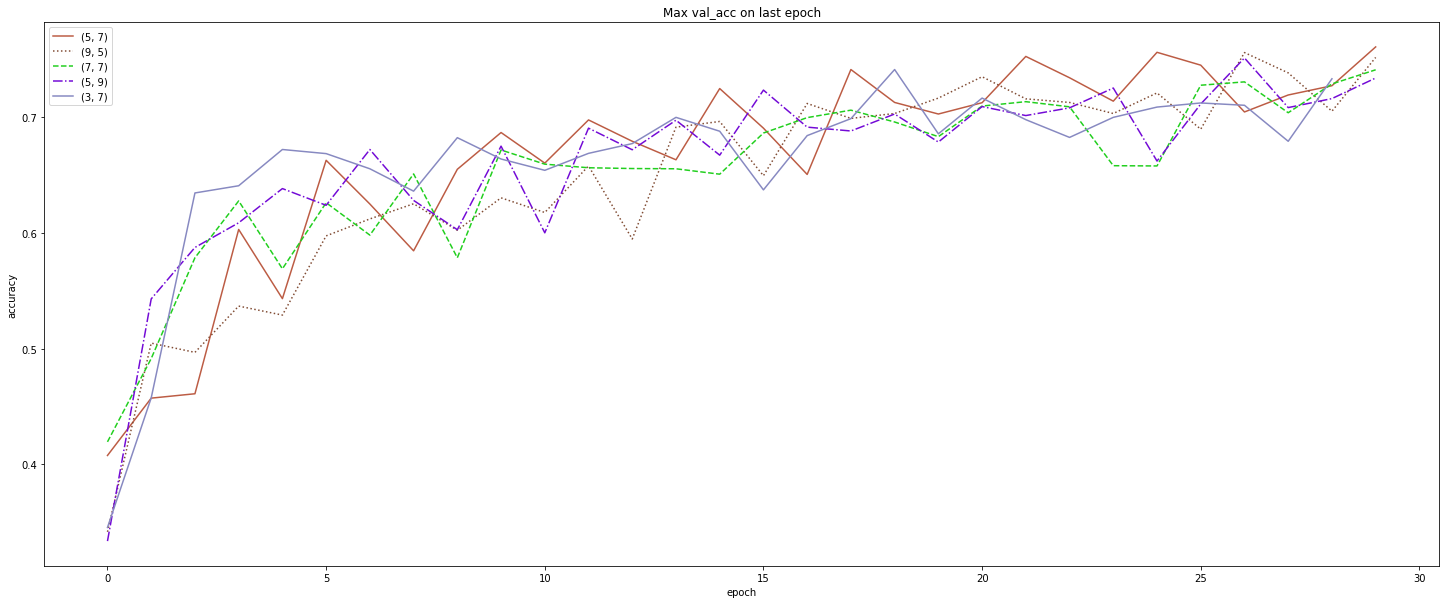

In [68]:
import pprint
kernels = [3, 5, 7, 9, 11]
# kernels = [3, 5]

kernel_combinations = [(a, b) for a in kernels for b in kernels]

model_patterns = [
            f"CL32C{k1}V~CL32C{k1}V~BN~P2~DO18 -> CL64C{k2}V~CL64C{k2}V~BN~P2~DO82 -> F -> D512~DO26 -> D256~DO62 -> D3"
            for (k1, k2) in kernel_combinations
]

# model_comparison(model_patterns[15:25], 30)

history = []
labels = []
for i, model_pattern in enumerate(model_patterns):
    try:
        history.append(pickle.load(open(f'{model_pattern}.pickle', "rb")))
        labels.append(str(kernel_combinations[i]))
    except:
        continue

# graph_model_comparison(history, labels)
# history_1, labels_1 = list(zip(*sorted(list(zip(history, labels)), key=lambda x: sum(x[0]['val_accuracy']))))
# graph_model_comparison(history_1[:5], labels_1[:5], title="Summed val_acc")
history_2, labels_2 = list(zip(*sorted(list(zip(history, labels)), key=lambda x: -x[0]['val_accuracy'][-1])))
graph_model_comparison(history_2[:5], labels_2[:5], title="Max val_acc on last epoch")
# pp = pprint.PrettyPrinter(width=41, compact=True)
# print(l[:5][1])
